# Setting

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_img_path = keras.utils.get_file(
    '101.jpg', 'https://www.taiwan.net.tw/att/1/big_scenic_spots/pic_7927_32.jpg'
)
style_reference_image_path = keras.utils.get_file(
    "udnie.jpg", "https://raw.githubusercontent.com/lengstrom/fast-style-transfer/master/examples/style/udnie.jpg"
)

# 產生檔案的字首
result_prefix = 'me'

# weight of the different components 
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# 產生圖片的尺寸 
width, height = keras.preprocessing.image.load_img(base_img_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


print(tf.__version__, ',', keras.__version__)

2.4.0 , 2.4.0


# Take a look for our images

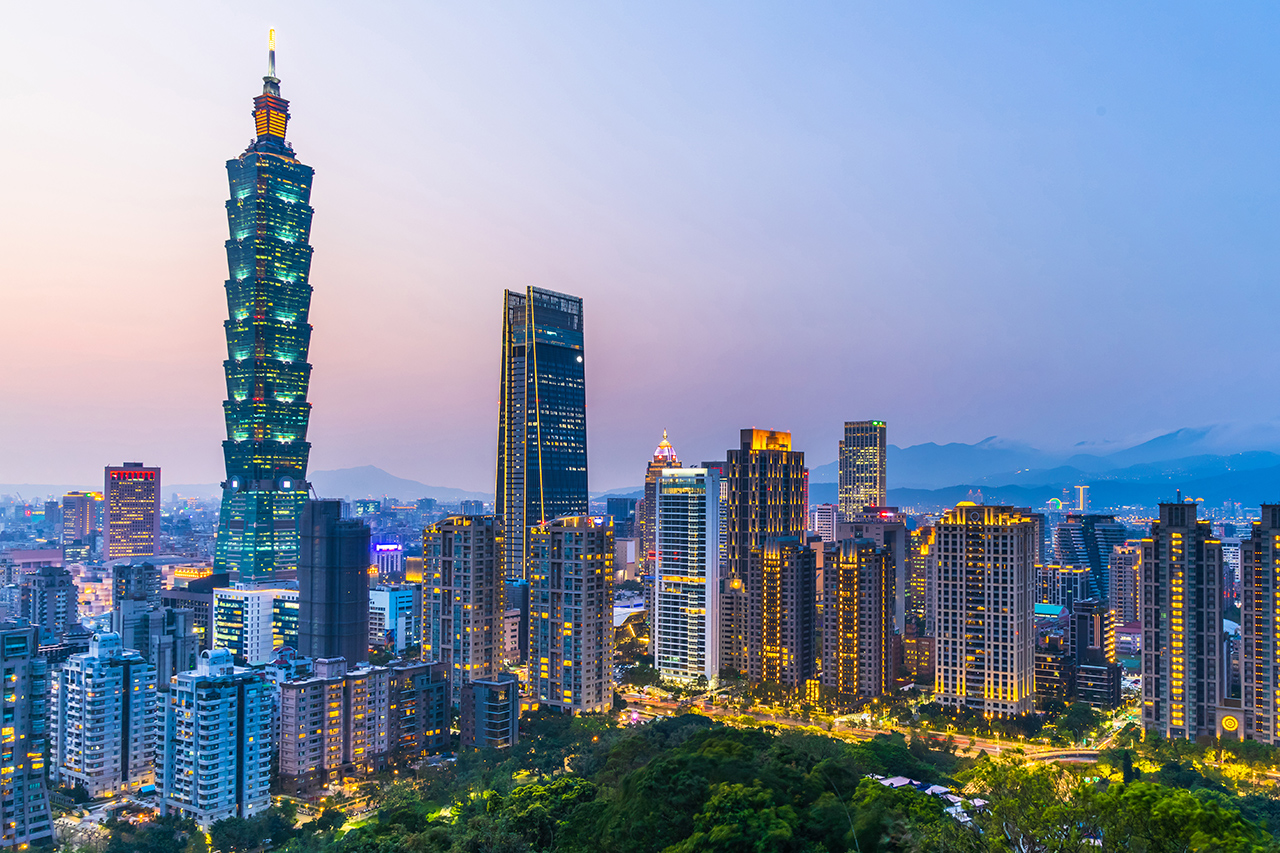

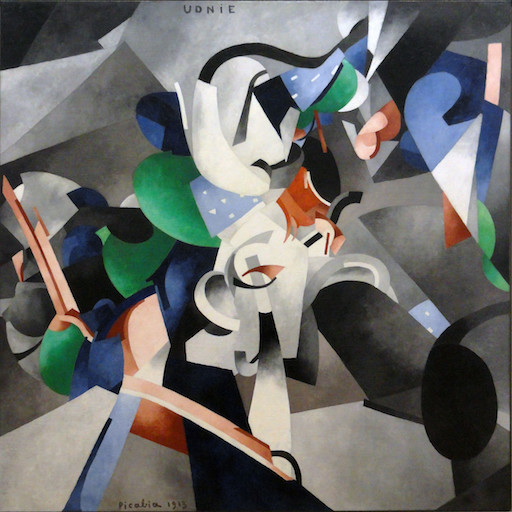

In [20]:
from IPython.display import Image, display

display(Image(base_img_path))
display(Image(style_reference_image_path))

# Image preprocessing / deprocessing utilities

In [21]:
def preprocess_img(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocedd_img(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # BRG -> RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Compute the style transfer loss

In [22]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels **2) * (size **2))

# MSE
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


def total_variation_loss(x):
    a = tf.square(
        x[:, :img_nrows -1, :img_ncols -1, :] - x[:, 1:, :img_ncols - 1, :]
    )
    b = tf.square(
        x[:, :img_nrows -1, :img_ncols -1, :] - x[:, :img_nrows -1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Create feature extraction model

In [23]:
model = vgg19.VGG19(weights='imagenet', include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

# Compute transfer loss

In [24]:
style_layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1', 
    'block4_conv1',
    'block5_conv1'
]
# the layer to use for the content loss
content_layer_name = 'block5_conv2'

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    # initialize the loss
    loss = tf.zeros(shape=())
    
    # add content loss
    layer_features = features[content_layer_name]
    base_img_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_img_features, combination_features
    )
    
    # add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl =style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
        
    # add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [25]:
# 將以下函式丟到tf.function編譯成tensorflow看得懂的形式
# GradienTape: 紀錄梯度
@tf.function
def comput_loss_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)  # combination_image 在 loss中佔了多少
    return loss, grads

# Training loop

In [26]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)
# input
base_image = preprocess_img(base_img_path)
style_reference_image = preprocess_img(style_reference_image_path)
combination_image = tf.Variable(preprocess_img(base_img_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = comput_loss_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 200 == 0:
        print('Interation %d: loss=%.2f' % (i, loss))
        img = deprocedd_img(combination_image.numpy())
        fname = result_prefix + '_at_interation_%d.png' % i
        keras.preprocessing.image.save_img(fname, img)

Interation 200: loss=2110.93
Interation 400: loss=1490.12
Interation 600: loss=1304.21
Interation 800: loss=1212.37
Interation 1000: loss=1155.89
Interation 1200: loss=1117.15
Interation 1400: loss=1088.62
Interation 1600: loss=1066.67
Interation 1800: loss=1049.08
Interation 2000: loss=1034.70
Interation 2200: loss=1022.83
Interation 2400: loss=1012.85
Interation 2600: loss=1004.32
Interation 2800: loss=996.95
Interation 3000: loss=990.54
Interation 3200: loss=984.91
Interation 3400: loss=979.95
Interation 3600: loss=975.56
Interation 3800: loss=971.66
Interation 4000: loss=968.17
